# MCMC {#sec-solutions-mcmc}

In [1]:
# Standard library imports
import os

# Third-party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import scipy.stats as stats
from scipy.special import expit  # Funzione logistica
from cmdstanpy import cmdstan_path, CmdStanModel

# Configuration
seed = sum(map(ord, "stan_poisson_regression"))
rng = np.random.default_rng(seed=seed)
az.style.use("arviz-darkgrid")
%config InlineBackend.figure_format = "retina"

# Define directories
home_directory = os.path.expanduser("~")
project_directory = f"{home_directory}/_repositories/psicometria"

# Print project directory to verify
print(f"Project directory: {project_directory}")

Project directory: /Users/corradocaudek/_repositories/psicometria


@sec-stan

@exr-laplace-births

Laplace adottò la seguente distribuzione campionaria per modellare il numero di maschi nati su un totale di $N$ nascite:

$$
y \sim \text{binomiale}(N, \theta),
$$

dove $N$ è il numero totale di nascite, $\theta$ è la probabilità di nascita di un maschio e $y$ è il numero di nascite maschili.

Laplace utilizzò la seguente distribuzione a priori per $\theta$:

$$
\theta \sim \text{beta}(1, 1),
$$

dove la distribuzione $\text{beta}(1, 1)$ è uniforme sull'intervallo $\theta \in (0, 1)$ poiché la densità è proporzionale a una costante:

$$
\text{beta}(\theta \mid 1, 1) \propto \theta^{1 - 1} \cdot (1 - \theta)^{1 - 1} = 1.
$$

Il modello di Laplace è abbastanza semplice da permettere una soluzione analitica della distribuzione a posteriori:

$$
\begin{aligned}
    p(\theta \mid y, N) &\propto p(y \mid N, \theta) \cdot p(\theta) \\
    &= \text{binomiale}(y \mid N, \theta) \cdot \text{beta}(\theta \mid 1, 1) \\
    &\propto \theta^y \cdot (1 - \theta)^{N - y} \cdot \theta^{1 - 1} \cdot (1 - \theta)^{1 - 1} \\
    &= \theta^{y} \cdot (1 - \theta)^{N - y} \\
    &\propto \text{beta}(\theta \mid y + 1, N - y + 1).
\end{aligned}
$$

Quindi, possiamo concludere che:

$$
p(\theta \mid y, N) = \text{beta}(\theta \mid y + 1, N - y + 1).
$$

Il seguente programma Stan richiede che vengano forniti dati, specificamente il numero di nascite maschili ($y$) e il numero totale di nascite ($N$). Il modello ci permetterà di stimare la probabilità di nascita di un maschio ($\theta$) e la probabilità che nascano più maschi che femmine ($\theta > 0.5$).

Ecco come possiamo specificare il modello Stan:

In [2]:
stan_file = os.path.join(project_directory, "stan", "sex-ratio.stan")

with open(stan_file, "r") as f:
    print(f.read())

data {
  int<lower = 0> N;
  int<lower = 0, upper = N> y;
  int<lower = 0> alpha_prior;
  int<lower = 0> beta_prior;
}
parameters {
  real<lower=0, upper=1> theta;
}
model {
  theta ~ beta(alpha_prior, beta_prior);
  y ~ binomial(N, theta);
}
generated quantities {
  int<lower=0, upper=1> boys_gt_girls = theta > 0.5;
}



In questo programma Stan, vediamo che sia il numero totale di nascite ($N$) sia il numero di nascite maschili ($y$) sono forniti come dati. Poi ci sono due blocchi aggiuntivi: un _blocco dei parametri_, usato per dichiarare valori sconosciuti (qui, solo il tasso di nascite maschili $\theta$), e un _blocco del modello_, dove specifichiamo la distribuzione a priori e la verosimiglianza. La distribuzione a posteriori viene calcolata da Stan combinando queste due componenti. Inoltre, c'è un *blocco delle quantità generate* dove viene calcolata una variabile booleana che indica se la probabilità di nascita dei maschi $\theta$ è maggiore di 0.5.

Il modello di Laplace e la sua implementazione in Stan ci permettono di affrontare il problema inverso delle nascite, inferendo la probabilità di nascita di un maschio dai dati osservati. Utilizzando le tecniche bayesiane, possiamo stimare non solo la probabilità di nascita di un maschio, ma anche la probabilità che nascano più maschi che femmine.

In [3]:
model = CmdStanModel(stan_file=stan_file)

Inseriamo i dati in un dizionario. 

In [4]:
boys = 110312
girls = 105287

data = {"N": boys + girls, "y": boys, "alpha_prior": 1, "beta_prior": 1}

print(data)

{'N': 215599, 'y': 110312, 'alpha_prior': 1, 'beta_prior': 1}


Eseguiamo il campionamento MCMC con la seguente chiamata.

In [5]:
sample = model.sample(
    data=data,
    iter_warmup=1000,
    iter_sampling=10_000,
    seed=123,
    show_progress=False,
    show_console=False,
)

08:58:53 - cmdstanpy - INFO - CmdStan start processing
08:58:53 - cmdstanpy - INFO - Chain [1] start processing
08:58:53 - cmdstanpy - INFO - Chain [2] start processing
08:58:53 - cmdstanpy - INFO - Chain [3] start processing
08:58:53 - cmdstanpy - INFO - Chain [4] start processing
08:58:53 - cmdstanpy - INFO - Chain [1] done processing
08:58:53 - cmdstanpy - INFO - Chain [2] done processing
08:58:53 - cmdstanpy - INFO - Chain [3] done processing
08:58:53 - cmdstanpy - INFO - Chain [4] done processing


Il metodo `$sample()` viene applicato al file eseguibile del modello Stan che abbiamo compilato e nominato `model`.

Avendo assunto una distribuzione a priori per il parametro $\theta$, l'algoritmo procede in maniera ciclica, aggiornando la distribuzione a priori di $\theta$ condizionandola ai valori già generati. Dopo un certo numero di iterazioni, l'algoritmo raggiunge la convergenza, e i valori estratti possono essere considerati campioni dalla distribuzione a posteriori di $\theta$.

All'inizio del campionamento, la distribuzione dei campioni può essere significativamente diversa dalla distribuzione stazionaria. Questo periodo iniziale è chiamato "burn-in". Durante il burn-in, i campioni possono non rappresentare accuratamente la distribuzione a posteriori e sono tipicamente scartati. Man mano che il numero di iterazioni aumenta, la distribuzione dei campioni si avvicina sempre più alla distribuzione target.

Dopo aver eseguito il modello in Stan, otteniamo una serie di campioni $\theta^{(m)}$ dalla distribuzione a posteriori $p(\theta \mid N, y)$. Ogni campione rappresenta un possibile valore di $\theta$ compatibile con i dati osservati $y$. Procediamo quindi a estrarre i campioni a posteriori per le variabili `theta` e `boys_gt_girls`.

In [6]:
theta_draws = sample.stan_variable("theta")
boys_gt_girls_draws = sample.stan_variable("boys_gt_girls")

Tracciando un istogramma di questi campioni, possiamo visualizzare dove i valori di $\theta$ sono più probabili e comprendere meglio la forma della distribuzione a posteriori. L'istogramma ci fornisce diverse informazioni:

- **Valore più probabile di $\theta$**: Questo è il valore intorno al quale i campioni sono più concentrati, noto come la moda della distribuzione.
- **Distribuzione dei possibili valori di $\theta$**: Questo ci dà un'idea dell'incertezza nella stima di $\theta$.

Se l'istogramma è stretto e concentrato attorno a un valore specifico, significa che c'è poca incertezza nella stima di $\theta$. In altre parole, possiamo essere abbastanza sicuri che il valore vero di $\theta$ sia vicino a questo valore.

Se l'istogramma è largo e distribuito, significa che c'è maggiore incertezza nella stima di $\theta$. Questo indica che i dati osservati non forniscono una stima precisa e che il valore di $\theta$ potrebbe variare notevolmente.

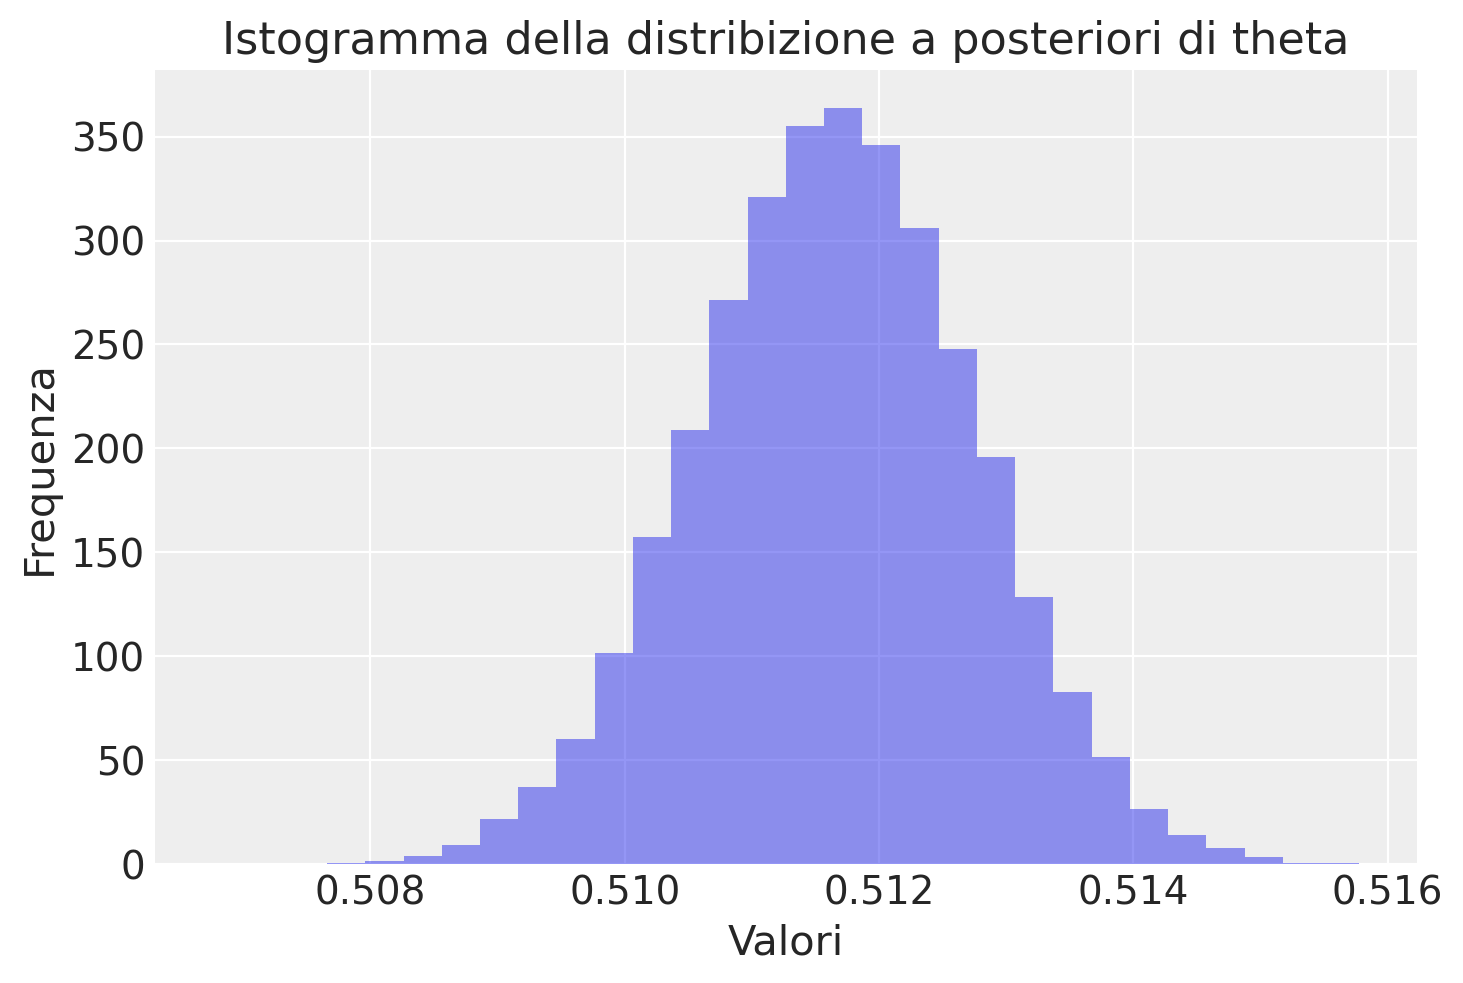

In [7]:
plt.hist(
    theta_draws,
    bins=30,
    alpha=0.5,
    density=True,
)
plt.title("Istogramma della distribizione a posteriori di theta")
plt.xlabel("Valori")
plt.ylabel("Frequenza")
plt.show()

In Stan, possiamo codificare direttamente il valore della funzione indicatrice e assegnarlo a una variabile nel blocco delle quantità generate.

```stan
generated quantities {
  int<lower=0, upper=1> boys_gt_girls = theta > 0.5;
}
```

Le espressioni condizionali come `theta > 0.5` assumono il valore 1 se sono vere e 0 se sono false. In notazione matematica, scriveremmo $\textrm{I}(\theta > 0.5)$, che assume valore 1 se $\theta > 0.5$ e 0 altrimenti. In Stan, come in C++, trattiamo `>` come un operatore binario che restituisce 0 o 1, quindi scriviamo semplicemente `theta > 0.5`.

In [ ]:
Pr_boy_gt_girl = np.mean(boys_gt_girls_draws)
print(f"estimated Pr[boy more likely] = {Pr_boy_gt_girl:.15f}")

Come possiamo vedere di seguito, tutti i nostri campioni per $\theta$ sono maggiori di $\frac{1}{2}$, ovvero `boys_gt_girls_draws` è sempre uguale a 1:

In [ ]:
np.unique(boys_gt_girls_draws)

Il valore 1 restituito come stima solleva l'importante problema della precisione numerica. Laplace calcolò il risultato analiticamente, che è

$$
\Pr\!\left[\Theta > \frac{1}{2} \ \bigg| \ N, y\right] \approx 1 - 10^{-27}.
$$

Quindi avremmo bisogno di un numero astronomico di campioni a posteriori prima di generare un valore di $\theta$ inferiore a $\frac{1}{2}$. Come detto, la risposta di 1.0 è molto vicina alla risposta vera e ben entro il nostro errore Monte Carlo atteso. 

# @sec-poisson-model {.unnumbered} 

@exr-poisson-model-1

1. **Distribuzione a posteriori per la Spagna e la Francia**: Dato che il numero di gol segue una distribuzione di Poisson, e il prior per λ è una distribuzione gamma, sappiamo che il posterior per λ sarà anch'esso una distribuzione gamma. 

   La distribuzione a posteriori gamma ha parametri aggiornati $\alpha' = \alpha + k$ e $\beta' = \beta + n$, dove $k$ è il numero di gol segnati e $n$ è il numero di partite osservate.

   Per la Spagna:
   $$
   \alpha_{Spagna}' = \alpha + k_{Spagna} = 1 + 5 = 6
   $$
   $$
   \beta_{Spagna}' = \beta + n = 1 + 1 = 2
   $$

   Per la Francia:
   $$
   \alpha_{Francia}' = \alpha + k_{Francia} = 1 + 3 = 4
   $$
   $$
   \beta_{Francia}' = \beta + n = 1 + 1 = 2
   $$

   Quindi, le distribuzioni a posteriori per λ sono:
   $$
   \lambda_{Spagna} \sim \text{Gamma}(6, 2)
   $$
   $$
   \lambda_{Francia} \sim \text{Gamma}(4, 2)
   $$

2. **Calcolo della probabilità di superiorità**: La probabilità che $λ_{Spagna} > λ_{Francia}$ può essere calcolata simulando valori da entrambe le distribuzioni a posteriori e calcolando la proporzione di volte in cui $λ_{Spagna} > λ_{Francia}$.

```python
import numpy as np
from scipy.stats import gamma

# Parametri posteriori per la Spagna
alpha_spagna = 6
beta_spagna = 2

# Parametri posteriori per la Francia
alpha_francia = 4
beta_francia = 2

# Numero di simulazioni
n_sim = 100000

# Simulazione delle distribuzioni a posteriori
lambda_spagna = gamma.rvs(alpha_spagna, scale=1/beta_spagna, size=n_sim)
lambda_francia = gamma.rvs(alpha_francia, scale=1/beta_francia, size=n_sim)

# Calcolo della probabilità di superiorità
prob_superiorita = np.mean(lambda_spagna > lambda_francia)

print(f"La probabilità di superiorità della Spagna sulla Francia è: {prob_superiorita:.4f}")
```

**Risultato:**

Il valore per la probabilità di superiorità della Spagna sulla Francia rappresenta la probabilità che la Spagna abbia un tasso medio di gol superiore rispetto alla Francia. Questa probabilità quantifica la fiducia che possiamo avere nel fatto che la Spagna sia, effettivamente, la squadra superiore in base al risultato osservato.
